In [1]:
# General
import sys
import os.path as op
from time import time
from collections import OrderedDict as od
from glob import glob
import itertools
import warnings
from importlib import reload
from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

# Stats
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from formatting import *
from helper_funcs import *
from eeg_plotting import plot_trace
from time_cells import (spike_sorting, spike_preproc,
                        events_preproc, events_proc,
                        time_bin_analysis, pop_decoding)

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

proj_dir = '/home1/dscho/projects/time_cells'

In [2]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*-Events.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


# Load subject-level place and time decoders.

In [3]:
def sort_onto(sort_on, 
              apply_to, 
              n_split=None):
    """Sort the values within each split of sort_on.
    
    Apply the sorting indices to apply_to."""
    # Split the input vectors.
    if (len(np.array(apply_to).shape) == 1) & (n_split is None):
        n_split = 1
    if n_split is not None:
        sort_on = np.split(np.ravel(sort_on), n_split)
        apply_to = np.split(np.array(apply_to), n_split)
    
    # Sort each row.
    apply_to = np.array(apply_to)
    assert len(apply_to.shape) == 2
    sort_idx = np.argsort(sort_on, axis=-1)
    apply_to = np.squeeze([apply_to[ii, sort_idx[ii, :]]
                           for ii in range(sort_idx.shape[0])])
    return apply_to


def clf_error(y_test, y_test_pred, err_mult=1):
    """Return the difference between predicted and actual values."""
    return list((np.array(y_test_pred) - np.array(y_test)) * err_mult)

In [41]:
for col in path_lens:
    path_lens[col] = path_lens[col].astype(int)

In [77]:
np.array_equal(np.tril(path_lens.values), np.triu(path_lens.values).T)

True

Saved /home1/dscho/projects/time_cells/figs/plot_behav/maze_path_length.pdf


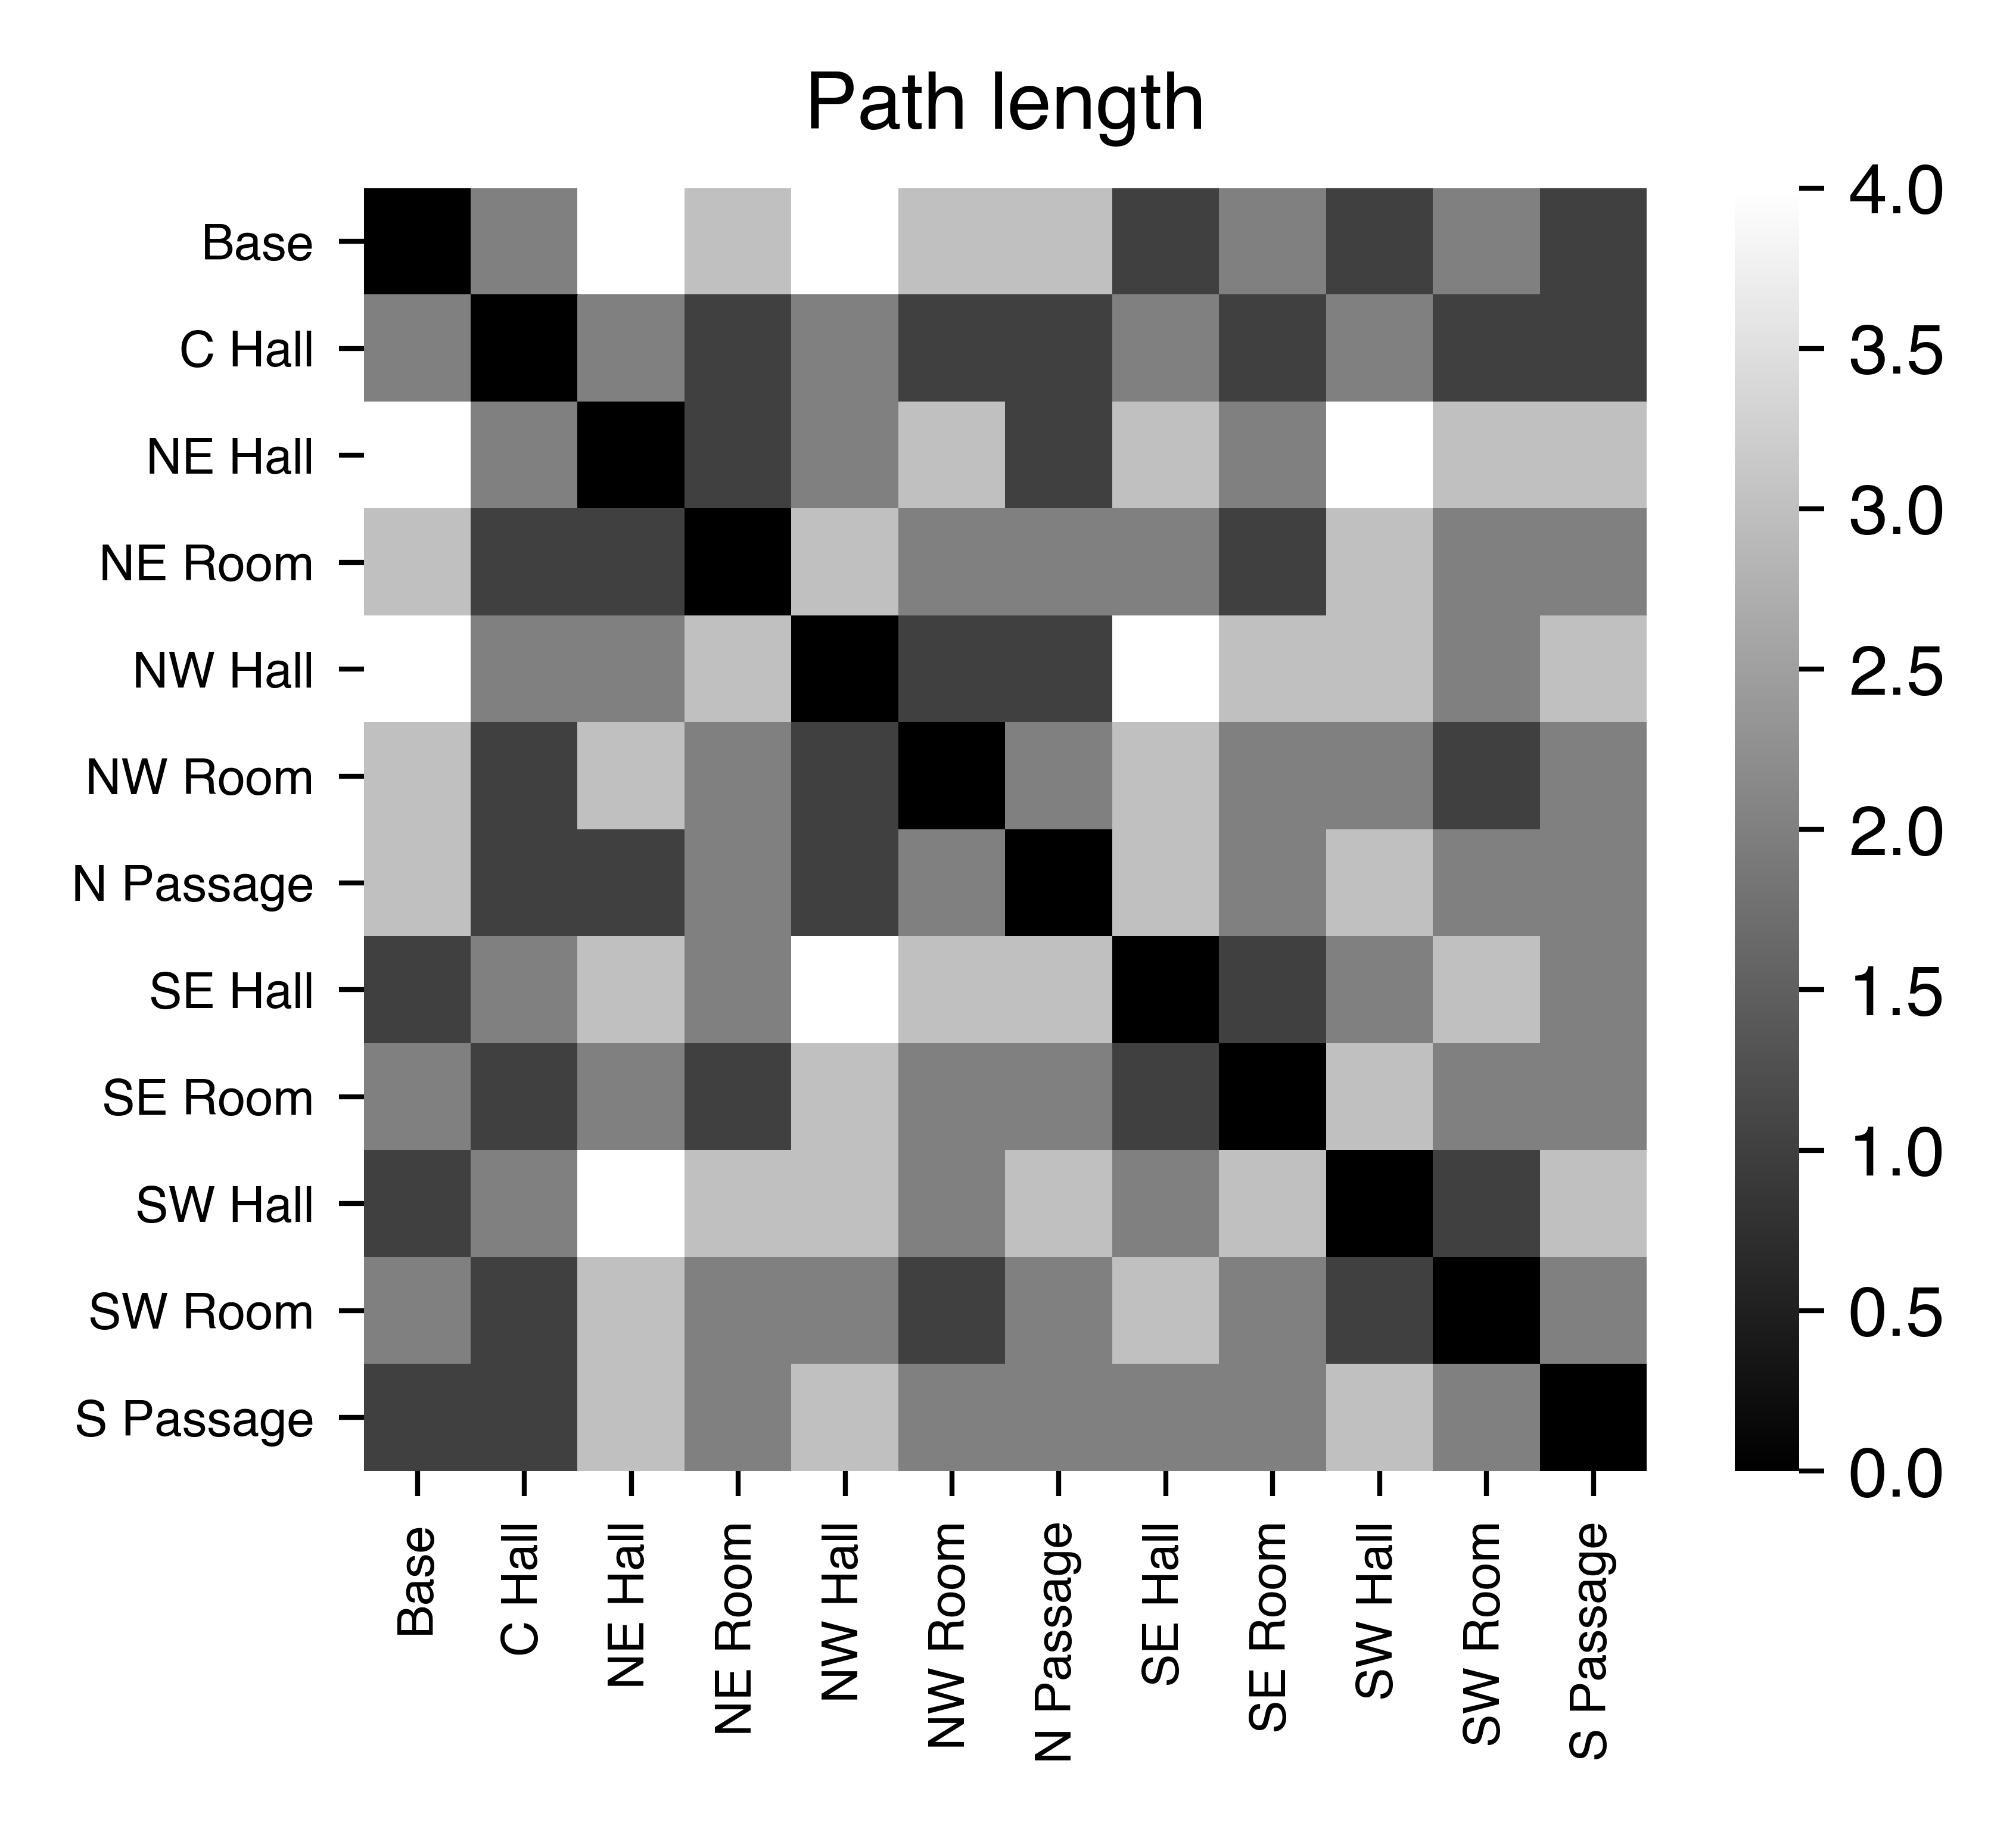

In [72]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.75)
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 8, 'annot': 5}
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5

fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.heatmap(path_lens.values, vmin=0, vmax=4, cmap='binary_r', square=True)
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(path_lens.shape[0]) + 0.5)
_ax.set_xticklabels([x.replace('_', ' ') for x in path_lens.index.tolist()], rotation=90)
_ax.set_yticks(np.arange(path_lens.shape[1]) + 0.5)
_ax.set_yticklabels([x.replace('_', ' ') for x in path_lens.columns.tolist()], rotation=0)
_ax.set_title('Path length', fontsize=font['fig'])

if savefig:
    filename = op.join('/home1/dscho/projects/time_cells',
                       'figs', 'plot_behav', 
                       'maze_path_length.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))

fig.show()

In [78]:
path_lens

,Base,C_Hall,NE_Hall,NE_Room,NW_Hall,NW_Room,N_Passage,SE_Hall,SE_Room,SW_Hall,SW_Room,S_Passage
Base,0,2,4,3,4,3,3,1,2,1,2,1
C_Hall,2,0,2,1,2,1,1,2,1,2,1,1
NE_Hall,4,2,0,1,2,3,1,3,2,4,3,3
NE_Room,3,1,1,0,3,2,2,2,1,3,2,2
NW_Hall,4,2,2,3,0,1,1,4,3,3,2,3
NW_Room,3,1,3,2,1,0,2,3,2,2,1,2
N_Passage,3,1,1,2,1,2,0,3,2,3,2,2
SE_Hall,1,2,3,2,4,3,3,0,1,2,3,2
SE_Room,2,1,2,1,3,2,2,1,0,3,2,2
SW_Hall,1,2,4,3,3,2,3,2,3,0,1,3


In [84]:
_df.apply(lambda x: [len(x['y_test']), len(x['y_test_null'])], axis=1)

0     [60, 60]
1     [60, 60]
2     [60, 60]
3     [60, 60]
4     [60, 60]
        ...   
67    [60, 60]
68    [60, 60]
69    [60, 60]
70    [60, 60]
71    [60, 60]
Length: 708, dtype: object

In [290]:
average = 'micro'
game_states = ['Encoding']
err_mult = 2

# ----------------------------------------------
# Load subject-level place decoder dataframes.
timer = Timer()

path_lens = dio.open_pickle('/home1/dscho/projects/time_cells/unity/maps/path_lengths.pkl')

globstr = op.join(proj_dir, 'analysis', 'classifiers',
                  'SVC_predicting_maze_region-{}-*.pkl')

clfs = []
clf_results = []
for subj_sess in sessions:
    fpath = glob(globstr.format(subj_sess))
    if len(fpath) == 1:
        _clf_results = dio.open_pickle(fpath[0])
        _clf_results.insert(0, 'subj_sess', subj_sess)
        clf_results.append(_clf_results)
clf_results = pd.concat(clf_results)
if 'subj' not in clf_results:
    clf_results.insert(0, 'subj', clf_results['subj_sess'].apply(lambda x: x.split('_')[0]))
if 'testvar' not in clf_results:
    clf_results.insert(0, 'testvar', 'place')

# Drop columns that we don't need.
drop_cols = ['mean_acc', 'acc_by_time', 'accuracy', 'clf',
             'mean_acc_null', 'acc_by_time_null', 'accuracy_null', 'clf_null']
for _df in (clf_results,):
    _drop_cols = [col for col in drop_cols if col in _df.columns]
    if len(_drop_cols) > 0:
        _df.drop(columns=_drop_cols, inplace=True)

# Calculate performance metrics.
for _df in (clf_results,):
    _df['recall'] = _df.apply(lambda x: metrics.recall_score(x['y_test'], x['y_test_pred'], average=average), axis=1)
    _df['precision'] = _df.apply(lambda x: metrics.precision_score(x['y_test'], x['y_test_pred'], average=average), axis=1)
    _df['f1'] = _df.apply(lambda x: metrics.f1_score(x['y_test'], x['y_test_pred'], average=average).tolist(), axis=1)
    _df['abs_err'] = _df.apply(lambda x: [path_lens.at[x['y_test'][ii], x['y_test_pred'][ii]]
                                          for ii in range(len(x['y_test']))
                                          if x['y_test'][ii]!='Base'
                                         ],
                               axis=1)
    _df['mean_abs_err'] = _df['abs_err'].apply(np.nanmean)
    
    _df['recall_null'] = _df.apply(lambda x: metrics.recall_score(x['y_test_null'], x['y_test_pred_null'], average=average), axis=1)
    _df['precision_null'] = _df.apply(lambda x: metrics.precision_score(x['y_test_null'], x['y_test_pred_null'], average=average), axis=1)
    _df['f1_null'] = _df.apply(lambda x: metrics.f1_score(x['y_test_null'], x['y_test_pred_null'], average=average).tolist(), axis=1)
    _df['abs_err_null'] = _df.apply(lambda x: [path_lens.at[x['y_test_null'][ii], x['y_test_pred_null'][ii]]
                                               for ii in range(len(x['y_test_null']))
                                               if x['y_test'][ii]!='Base'
                                              ], axis=1)
    _df['mean_abs_err_null'] = _df['abs_err_null'].apply(np.nanmean)
    
clfs.append(clf_results)

# ----------------------------------------------
# Load subject-level time decoders.
testvar = 'time_step'
clf_results = []
for subj_sess in sessions:
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=0)
    for game_state in game_states:
        globstr = op.join(proj_dir, 'analysis', 'classifiers',
                          'SVC_predicting_{}-{}-{}units-{}-random_search-*fold.pkl'
                          .format(testvar, subj_sess, len(event_spikes.column_map['neurons']), game_state))
        files = glob(globstr)
        assert len(files) == 1
        clf_results.append(dio.open_pickle(files[0]))
clf_results = pd.concat(clf_results)
if 'subj' not in clf_results:
    clf_results.insert(0, 'subj', clf_results['subj_sess'].apply(lambda x: x.split('_')[0]))
if 'testvar' not in clf_results:
    clf_results.drop(columns=['testvar'])
    clf_results.insert(0, 'testvar', 'time')
    
# --------------------------
# Resort y_test_null and y_test_pred_null on the values within each y_test_null test trial.
for _df in (clf_results,):
    cols = ['accuracy_null', 'acc_by_time_null', 'y_test_pred_null', 'y_test_null']
    cols = [col for col in cols if col in _df.columns]
    for col in cols:
        _df[col] = _df.apply(lambda x: sort_onto(x['y_test_null'], x[col], len(x['test_trials'])), axis=1)
        
# Drop columns that we don't need.
drop_cols = ['mean_acc', 'acc_by_time', 'accuracy', 'clf',
             'mean_acc_null', 'acc_by_time_null', 'accuracy_null', 'clf_null']
for _df in (clf_results,):
    _drop_cols = [col for col in drop_cols if col in _df.columns]
    if len(_drop_cols) > 0:
        _df.drop(columns=_drop_cols, inplace=True)

# Calculate performance metrics.
for _df in (clf_results,):
    _df['recall'] = _df.apply(lambda x: metrics.recall_score(x['y_test'], x['y_test_pred'], average=average), axis=1)
    _df['precision'] = _df.apply(lambda x: metrics.precision_score(x['y_test'], x['y_test_pred'], average=average), axis=1)
    _df['f1'] = _df.apply(lambda x: metrics.f1_score(x['y_test'], x['y_test_pred'], average=average).tolist(), axis=1)
    _df['err'] = _df.apply(lambda x: clf_error(x['y_test'], x['y_test_pred'], err_mult=err_mult), axis=1)
    _df['abs_err'] = _df.apply(lambda x: np.abs(x['err']).tolist(), axis=1)
    _df['mean_abs_err'] = _df['abs_err'].apply(np.nanmean)
    
    _df['recall_null'] = _df.apply(lambda x: metrics.recall_score(x['y_test_null'], x['y_test_pred_null'], average=average), axis=1)
    _df['precision_null'] = _df.apply(lambda x: metrics.precision_score(x['y_test_null'], x['y_test_pred_null'], average=average), axis=1)
    _df['f1_null'] = _df.apply(lambda x: metrics.f1_score(x['y_test_null'], x['y_test_pred_null'], average=average).tolist(), axis=1)
    _df['error_null'] = _df.apply(lambda x: clf_error(x['y_test_null'], x['y_test_pred_null'], err_mult=err_mult), axis=1)
    _df['abs_err_null'] = _df.apply(lambda x: np.abs(x['error_null']).tolist(), axis=1)
    _df['mean_abs_err_null'] = _df['abs_err_null'].apply(np.nanmean)
    
clfs.append(clf_results)
clfs = (pd.concat(clfs, axis=0)
        .query("(gameState_train==gameState_test=={})".format(game_states))
        .reset_index(drop=True))
clfs.insert(clfs.columns.tolist().index('test_trials')+1,
            'test_trial',
            clfs['test_trials'].apply(lambda x: x[0]))
clfs.drop(columns=['test_trials'], inplace=True)

cols = ['subj', 'subj_sess', 'gameState_train', 'gameState_test', 'test_trial',
        'y_test', 'y_test_pred', 'abs_err', 'mean_abs_err',
        'y_test_null', 'y_test_pred_null', 'abs_err_null', 'mean_abs_err_null']
grp_cols = ['testvar', 'subj', 'subj_sess', 'gameState_train', 'gameState_test', 'test_trial']
clfs = pd.merge(clfs.sort_values(grp_cols).query("(testvar=='place')")[cols],
                clfs.sort_values(grp_cols).query("(testvar=='time_step')")[cols],
                on=grp_cols[1:], suffixes=('_place', '_time')).reset_index(drop=True)

keep_idx = np.where(np.isfinite(clfs['mean_abs_err_place']))[0]
clfs = clfs.iloc[keep_idx].reset_index(drop=True)

print('clfs: {}'.format(clfs.shape))
print(timer)

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/pandas/core/series.py:4213: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(values, f, convert=convert_dtype)


clfs: (354, 21)
Ran in 13.9s


In [195]:
# Load all gold view events.
output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events'
gold_views = []
for subj_sess in np.unique(clfs['subj_sess']):
    filename = op.join(output_dir, '{}-gold_views.pkl'.format(subj_sess))
    gold_views.append(dio.open_pickle(filename))
gold_views = pd.concat(gold_views, axis=0).reset_index()

# Get the no. of (viewed) golds dug on each trial, for each session.
gold_dug = (gold_views
            .groupby(['subj_sess', 'trial', 'gold_id'])
            .agg({'dur': np.sum,
                  'dig_success': lambda x: np.any(x) * 1})
            .reset_index()
            .groupby(['subj_sess', 'trial'])
            .agg({'dur': np.sum,
                  'dig_success': np.sum}))

print('gold_views: {}, gold_dug: {}'.format(gold_views.shape, gold_dug.shape))

gold_views: (594, 11), gold_dug: (277, 2)


In [264]:
# Get prop. time spent moving during each Encoding trial.
is_moving = []
for subj_sess in np.unique(clfs['subj_sess']):
    events = events_proc.load_events(subj_sess, verbose=False)
    is_moving.append(pd.DataFrame([[subj_sess,
                                    trial, 
                                    np.mean(np.concatenate(df.apply(lambda x: np.repeat(x['moved_pos'],
                                                                                        x['dur']),
                                                                    axis=1).tolist()))]
                                   for (trial, df) in events.positions.query("(gameState=='Encoding')").groupby('trial')],
                                  columns=['subj_sess', 'trial', 'is_moving']))
    
is_moving = pd.concat(is_moving, axis=0).set_index(['subj_sess', 'trial'])

In [302]:
clfs.insert(clfs.columns.tolist().index('test_trial')+1,
            'is_moving',
            clfs.apply(lambda x: is_moving['is_moving'].get((x['subj_sess'], x['test_trial']), 0), axis=1))
clfs.insert(clfs.columns.tolist().index('test_trial')+2,
            'gold_view_dur',
            clfs.apply(lambda x: gold_dug['dur'].get((x['subj_sess'], x['test_trial']), 0), axis=1))
clfs.insert(clfs.columns.tolist().index('test_trial')+3,
            'gold_dug',
            clfs.apply(lambda x: gold_dug['dig_success'].get((x['subj_sess'], x['test_trial']), 0), axis=1))

In [303]:
def _test(obs, null):
    n = len(obs)
    dof = n - 1
    mean_obs = np.mean(obs)
    mean_null = np.mean(null)
    sem_obs = np.mean(obs)
    sem_null = np.mean(null)
    tval, pval = stats.ttest_rel(obs, null)
    output = ('obs err: {:.1f} ± {:.1f}; null err: {:.1f} ± {:.1f}; t({}) = {:.1f}, p = {:.4f}'
              .format(mean_obs, sem_obs, mean_null, sem_null, dof, tval, pval))
    return output

print('Subject-level decoding accuracy:', '-'*31, sep='\n')
for testvar in ['time', 'place']:
    for (subj, subj_sess), df in clfs.groupby(['subj', 'subj_sess']):
        print('{:>5}, {}: {}'.format(testvar, subj_sess,
                                     _test(df['mean_abs_err_{}'.format(testvar)].values,
                                           df['mean_abs_err_null_{}'.format(testvar)].values)))
    print()
    
print('Time ~ place decoding accuracy across trials:', '-'*45, sep='\n')
for (subj, subj_sess), df in clfs.groupby(['subj', 'subj_sess']):
    rval, pval = stats.pearsonr(df['mean_abs_err_time'],
                                df['mean_abs_err_place'])
    print('{}: r = {:>5.2f}, p = {}'
          .format(subj_sess, rval, pval))

Subject-level decoding accuracy:
-------------------------------
 time, U518_ses0: obs err: 6.9 ± 6.9; null err: 10.1 ± 10.1; t(35) = -6.4, p = 0.0000
 time, U518_ses1: obs err: 7.0 ± 7.0; null err: 10.1 ± 10.1; t(32) = -7.1, p = 0.0000
 time, U521_ses0: obs err: 9.1 ± 9.1; null err: 10.3 ± 10.3; t(32) = -3.0, p = 0.0054
 time, U526_ses0: obs err: 6.7 ± 6.7; null err: 10.0 ± 10.0; t(35) = -8.2, p = 0.0000
 time, U527_ses0: obs err: 8.1 ± 8.1; null err: 9.9 ± 9.9; t(35) = -4.6, p = 0.0001
 time, U530_ses0: obs err: 7.0 ± 7.0; null err: 10.4 ± 10.4; t(34) = -7.0, p = 0.0000
 time, U530_ses1: obs err: 8.2 ± 8.2; null err: 9.8 ± 9.8; t(35) = -3.2, p = 0.0028
 time, U532_ses0: obs err: 8.0 ± 8.0; null err: 10.0 ± 10.0; t(32) = -3.2, p = 0.0029
 time, U536_ses0: obs err: 7.2 ± 7.2; null err: 10.3 ± 10.3; t(35) = -7.7, p = 0.0000
 time, U540_ses0: obs err: 7.3 ± 7.3; null err: 9.9 ± 9.9; t(35) = -6.2, p = 0.0000

place, U518_ses0: obs err: 1.8 ± 1.8; null err: 1.7 ± 1.7; t(35) = 0.9, p = 0.36

In [305]:
testvars = ['is_moving', 'gold_view_dur', 'mean_abs_err_time', 'mean_abs_err_place']

[display(subj_sess, df[testvars+['gold_dug']].corr())
 for (subj_sess, df) in clfs.groupby(['subj_sess'])]

'U518_ses0'

,is_moving,gold_view_dur,mean_abs_err_time,mean_abs_err_place,gold_dug
is_moving,1.000000,-0.376225,-0.342020,0.488527,-0.472342
gold_view_dur,-0.376225,1.000000,0.282937,0.092182,0.601699
mean_abs_err_time,-0.342020,0.282937,1.000000,0.154367,0.284332
mean_abs_err_place,0.488527,0.092182,0.154367,1.000000,-0.213214
gold_dug,-0.472342,0.601699,0.284332,-0.213214,1.000000


'U518_ses1'

,is_moving,gold_view_dur,mean_abs_err_time,mean_abs_err_place,gold_dug
is_moving,1.000000,-0.176954,-0.261894,-0.106640,-0.286141
gold_view_dur,-0.176954,1.000000,-0.063174,0.110984,0.563507
mean_abs_err_time,-0.261894,-0.063174,1.000000,-0.150739,0.246190
mean_abs_err_place,-0.106640,0.110984,-0.150739,1.000000,0.224395
gold_dug,-0.286141,0.563507,0.246190,0.224395,1.000000


'U521_ses0'

,is_moving,gold_view_dur,mean_abs_err_time,mean_abs_err_place,gold_dug
is_moving,1.000000,-0.383295,-0.215929,0.450247,-0.347475
gold_view_dur,-0.383295,1.000000,0.261764,-0.298526,0.417314
mean_abs_err_time,-0.215929,0.261764,1.000000,0.032110,0.334299
mean_abs_err_place,0.450247,-0.298526,0.032110,1.000000,-0.503475
gold_dug,-0.347475,0.417314,0.334299,-0.503475,1.000000


'U526_ses0'

,is_moving,gold_view_dur,mean_abs_err_time,mean_abs_err_place,gold_dug
is_moving,1.000000,-0.304000,0.181709,0.582936,-0.122402
gold_view_dur,-0.304000,1.000000,-0.092145,-0.105458,0.573259
mean_abs_err_time,0.181709,-0.092145,1.000000,0.183345,-0.068971
mean_abs_err_place,0.582936,-0.105458,0.183345,1.000000,0.005316
gold_dug,-0.122402,0.573259,-0.068971,0.005316,1.000000


'U527_ses0'

,is_moving,gold_view_dur,mean_abs_err_time,mean_abs_err_place,gold_dug
is_moving,1.000000,-0.076845,-0.204136,0.594936,-0.226239
gold_view_dur,-0.076845,1.000000,0.103042,0.115035,0.546584
mean_abs_err_time,-0.204136,0.103042,1.000000,-0.002221,0.008431
mean_abs_err_place,0.594936,0.115035,-0.002221,1.000000,-0.240733
gold_dug,-0.226239,0.546584,0.008431,-0.240733,1.000000


'U530_ses0'

,is_moving,gold_view_dur,mean_abs_err_time,mean_abs_err_place,gold_dug
is_moving,1.000000,-0.516604,-0.241802,0.741187,-0.520495
gold_view_dur,-0.516604,1.000000,0.266430,-0.291269,0.535673
mean_abs_err_time,-0.241802,0.266430,1.000000,-0.262818,0.030248
mean_abs_err_place,0.741187,-0.291269,-0.262818,1.000000,-0.350825
gold_dug,-0.520495,0.535673,0.030248,-0.350825,1.000000


'U530_ses1'

,is_moving,gold_view_dur,mean_abs_err_time,mean_abs_err_place,gold_dug
is_moving,1.000000,0.116725,-0.343037,0.720535,0.006861
gold_view_dur,0.116725,1.000000,-0.192231,0.373864,0.413936
mean_abs_err_time,-0.343037,-0.192231,1.000000,-0.170775,-0.398201
mean_abs_err_place,0.720535,0.373864,-0.170775,1.000000,0.120463
gold_dug,0.006861,0.413936,-0.398201,0.120463,1.000000


'U532_ses0'

,is_moving,gold_view_dur,mean_abs_err_time,mean_abs_err_place,gold_dug
is_moving,1.000000,0.068155,-0.348079,0.511684,-0.003588
gold_view_dur,0.068155,1.000000,-0.162051,-0.065915,0.780137
mean_abs_err_time,-0.348079,-0.162051,1.000000,-0.381984,-0.147457
mean_abs_err_place,0.511684,-0.065915,-0.381984,1.000000,-0.147417
gold_dug,-0.003588,0.780137,-0.147457,-0.147417,1.000000


'U536_ses0'

,is_moving,gold_view_dur,mean_abs_err_time,mean_abs_err_place,gold_dug
is_moving,1.000000,-0.513699,-0.053379,0.732870,-0.164695
gold_view_dur,-0.513699,1.000000,0.098226,-0.364954,0.444350
mean_abs_err_time,-0.053379,0.098226,1.000000,0.183669,-0.145463
mean_abs_err_place,0.732870,-0.364954,0.183669,1.000000,-0.240911
gold_dug,-0.164695,0.444350,-0.145463,-0.240911,1.000000


'U540_ses0'

,is_moving,gold_view_dur,mean_abs_err_time,mean_abs_err_place,gold_dug
is_moving,1.000000,-0.399915,-0.101765,0.498619,-0.299311
gold_view_dur,-0.399915,1.000000,0.304623,-0.148613,0.551962
mean_abs_err_time,-0.101765,0.304623,1.000000,0.169414,-0.024532
mean_abs_err_place,0.498619,-0.148613,0.169414,1.000000,-0.275636
gold_dug,-0.299311,0.551962,-0.024532,-0.275636,1.000000


[None, None, None, None, None, None, None, None, None, None]

In [306]:
testvars = ['is_moving', 'gold_view_dur', 'mean_abs_err_time', 'mean_abs_err_place']

rvals = {testvar: [] for testvar in testvars}
for testvar in testvars:
    title = 'Gold dug ~ {}:'.format(testvar)
    print(title, '-'*len(title), sep='\n')
    for (subj, subj_sess), df in clfs.groupby(['subj', 'subj_sess']):
        rval, pval = stats.pearsonr(df['gold_dug'],
                                    df[testvar])
        rvals[testvar].append(rval)
        print('{:>5}, {}: r = {:>5.2f}, p = {}'
              .format(testvar, subj_sess, rval, pval))
        
    print()
    
title = 'Cross-session stats'
print(title, '-'*len(title), sep='\n')
for testvar in rvals:
    _mean = np.mean(rvals[testvar])
    _sem = stats.sem(rvals[testvar])
    tval, pval = stats.ttest_1samp(rvals[testvar], popmean=0)
    dof = len(rvals[testvar]) - 1
    print('{:>18}: r = {:>5.2f} ± {:<5.2f}, t({}) = {:.1f}, p = {}'
          .format(testvar, _mean, _sem, dof, tval, pval))

Gold dug ~ is_moving:
---------------------
is_moving, U518_ses0: r = -0.47, p = 0.0036289076811207815
is_moving, U518_ses1: r = -0.29, p = 0.1064557531413984
is_moving, U521_ses0: r = -0.35, p = 0.0475515441814387
is_moving, U526_ses0: r = -0.12, p = 0.4769760115822975
is_moving, U527_ses0: r = -0.23, p = 0.18457273734815213
is_moving, U530_ses0: r = -0.52, p = 0.0013490140398969151
is_moving, U530_ses1: r =  0.01, p = 0.9683223332161425
is_moving, U532_ses0: r = -0.00, p = 0.9841882430230522
is_moving, U536_ses0: r = -0.16, p = 0.33712089240719545
is_moving, U540_ses0: r = -0.30, p = 0.07616366808287123

Gold dug ~ gold_view_dur:
-------------------------
gold_view_dur, U518_ses0: r =  0.60, p = 0.0001037220665856488
gold_view_dur, U518_ses1: r =  0.56, p = 0.0006385170792184803
gold_view_dur, U521_ses0: r =  0.42, p = 0.015681187208608456
gold_view_dur, U526_ses0: r =  0.57, p = 0.00025767274871513484
gold_view_dur, U527_ses0: r =  0.55, p = 0.0005626661118103455
gold_view_dur, U530

In [307]:
# testvars = ['is_moving', 'gold_view_dur', 'mean_abs_err_time', 'mean_abs_err_place']
testvars = ['gold_view_dur', 'mean_abs_err_time', 'mean_abs_err_place']
# testvars = ['mean_abs_err_time', 'mean_abs_err_place']

tvals = {testvar: [] for testvar in testvars}
title = 'Session-level OLS regression'
print(title, '-'*len(title), sep='\n')
for (subj, subj_sess), df in clfs.groupby(['subj', 'subj_sess']):
    Y = df['gold_dug']
    X = sm.add_constant(df[testvars])
    mod = sm.OLS(Y, X)
    res = mod.fit()
    for testvar in testvars:
        tvals[testvar].append(res.tvalues[testvar])
    print(subj_sess, res.summary(), end='\n'*3)
    
title = 'Cross-session stats'
print(title, '-'*len(title), sep='\n')
for testvar in tvals:
    _mean = np.mean(tvals[testvar])
    _sem = stats.sem(tvals[testvar])
    tval, pval = stats.ttest_1samp(tvals[testvar], popmean=0)
    dof = len(tvals[testvar]) - 1
    print('{:>18}: r = {:>5.2f} ± {:<5.2f}, t({}) = {:.1f}, p = {}'
          .format(testvar, _mean, _sem, dof, tval, pval))

Session-level OLS regression
----------------------------
U518_ses0                             OLS Regression Results                            
Dep. Variable:               gold_dug   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     9.064
Date:                Thu, 14 Apr 2022   Prob (F-statistic):           0.000172
Time:                        19:28:50   Log-Likelihood:                -13.613
No. Observations:                  36   AIC:                             35.23
Df Residuals:                      32   BIC:                             41.56
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------